# Create and run a RAG pipeline from scratch 

## Why RAG?

Main goal is to improve the generation of outputs of LLMs
1. Prevents hallucinations: LLMs are good text but it might not be *factual*. RAG can help LLMs generate information based on relevant passages that are factual
2. Work with Custom Data Base LLMs are trained with internet-scale data[they have good understanding of language in general] however it means that many responses can be generic in nature. RAG helps building specific responses based on specific documents.

## RAG Use Cases

* Customer Support Q/A Chat- Treat existing customer support docs as resource documents and we could build a retrieval system to retrieve relevant document snippets and then have LLM craft snippets into answer when a customer asks a question.
  
* Email Chain Analysis: RAG can be used to find relevant info from any long email chains and use LLMs to process that info into structured data

* Company Internal Documentation Chat

* Textbook Q/A


Common pattern: Take in relevant documents to a query and process them with an LLM

For this we can consider LLM as a calculator for words

## Why run Locally?

Privacy, Speed, Cost

* Privacy: Private Documentation no one would want to send to an API. It is better to setup an LLM and run on your own hardware

* Speed: While using API, data is to be transmitted over the internet which takes time. Running it locally would remove that lag drastically as trasmisstion of data is not done.

* Cost: It may be a large cost to begin with but considering over time, no API fee or restrictions.

* No Vendor Lockin: If you rely on any other service, say OpenAI, having your system locally doesn't affect you.

## What is built?

Building a chatbot to chat with a pdf document
1. Open a PDF document - single PDF or collection of PDFs
2. Format PDF text to prepare for embedding model
3. Embed al of chunks of text in the PDF and turn them into numerical representations[embedding] which can be stored
4. Build a retreval system that uses vector search to find relevant chunk or text based on a query
5. Create a prompt that incorporates the retrieved pieces of text
6. Generate answer to the query based on passages of PDF with an LLM

* *Step 1-3:* Document Preprocessing and embedding generation

* *Step 4-6*:Search and answer

## Document/text processing and embedding creation

* Requirements: A document[Using a PDF for this]
* Embedding model of choice

Steps:
1. Import PDF document
2. Process text for embedding: {example splitting into chunks of sentences}
3. Embed text chunks with embedding model
4. Save embeddings to file for later use

## Importing PDF Document

In [1]:
#Download PDF File

import os
import requests

pdf_path =  "human-nutrition-text.pdf" #Getting PDF document

#Download file if it doesn't exist
if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading......")
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    filename = pdf_path
    response = requests.get(url)
    if response.status_code == 200:
        print(f"[INFO] Status Code: {response.status_code}")
        with open(filename,"wb") as file:
            file.write(response.content)
        print(f"[INFO] File has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to download PDF, Status Code: {response.status_code}")
else:
    print(f"[INFO] File {pdf_path} exists.")

[INFO] File human-nutrition-text.pdf exists.


## Opening the downloaded PDF now

In [2]:
import fitz # the pymupdf to read pdf documents
from tqdm.auto import tqdm # for progess bars

def text_formatter(text: str) -> str:
    cleaned_text = text.replace("\n"," ").strip() # this might be different based on each document so test this formatting based on document
    return cleaned_text

# Open PDF and get the lines/pages
# It will focus on test and not in images/figures etc.
def open_and_read_pdf(pdf_path:str) -> list[dict]:
    '''
    Opens a PDF file, read its text context page by page.

    Parameters: pdf_path(str): The file path to the pdf document to be opened and read

    Returns: list[dict]: A list of dictionaries, each containing the page number(modified), character count, word count, sentence count, token count and extracted text for each page
    '''
    doc = fitz.open(pdf_path) # opening a document
    pages_and_text = []

    for page_number, page in tqdm(enumerate(doc)): # iterate through document pages
        text = page.get_text() # get plain text encoded as UTF-8 format
        text = text_formatter(text = text)
        pages_and_text.append({"page_number" : page_number - 41, # adjusting the page numbers since actual PDF starts on page 42
                               "page_char_count": len(text),
                               "page_word_count": len(text.split(" ")),
                               "page_sentence_count": len(text.split(". ")),
                               "page_token_count": len(text)/4, # 1 token = ~4 characters
                               "text": text})
    return pages_and_text
pages_and_text = open_and_read_pdf(pdf_path=pdf_path)

0it [00:00, ?it/s]

In [3]:
import random 

random.sample(pages_and_text, k = 3)

[{'page_number': 844,
  'page_char_count': 1783,
  'page_word_count': 416,
  'page_sentence_count': 5,
  'page_token_count': 445.75,
  'text': 'Vegetables  Fruits  Protein-rich  foods  Grain  products  Other foods  and snacks  Small pieces  of raw  vegetable  (like raw  carrot  rounds,  baby  carrots,  string  beans, or  celery), or  other raw,  partially  cooked  vegetables  Raw green  peas  Cooked or  uncooked  whole corn  kernels  Large,  hard pieces  of uncooked  dried  vegetables    Apples or  other hard  pieces of  raw fruit,  especially  those with  hard pits or  seeds  Large, hard  pieces of  uncooked  dried fruits  Whole  pieces of  canned fruit  Whole  grapes,  cherries,  berries,  melon balls,  or cherry  and grape  tomatoes    Tough or  large chunks  of meat  Hot dogs,  meat sticks,  or sausages  (even when  cut into  round slices)  Fish with  bones  Large  chunks of  cheese or  string  cheese  Peanuts,  nuts, or  seeds (like  sunflower or  pumpkin  seeds)  Chunks or  spoon

In [4]:
#convert the list[dict] to a data frame for easy analysis
import pandas as pd

df = pd.DataFrame(pages_and_text)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
# getting stats on the current extracted text
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


## Why is token count significant?

It is important to consider token count because:
* Embedding models don't handle infinite tokens
* LLMs don't handle infinite tokens

Say and embedding model may have been trained to embed sequences of 384 tokens into numerical space (*sentence-transformers  all-mpnet-base-v2*)

As for LLMs, they can't accept infinite tokens in their context window[no. of tokens LLM can accept as input] 

## Further Text Processing: Splitting Pages into Sentences

Ways to do so:

1. Splitting on ". "
2. Do with NLP[Natural Language Library] library: spacy and nltk

In [6]:
from spacy.lang.en import English 
nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# Example
doc = nlp("This is sentence one. This is another sentence. I love elephants but, i love tigers even more.")
assert len(list((doc.sents))) == 3

# Access the sentences formed
list(doc.sents)

[This is sentence one.,
 This is another sentence.,
 I love elephants but, i love tigers even more.]

In [7]:
for item in tqdm(pages_and_text):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Making sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Counting the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [8]:
# Inspecting an example
random.sample(pages_and_text, k = 1)

[{'page_number': 154,
  'page_char_count': 1170,
  'page_word_count': 202,
  'page_sentence_count': 8,
  'page_token_count': 292.5,
  'text': '“Osmosis” by  Mariana  Ruiz  /  Public  Domain  Cells maintain water volume by actively controlling electrolyte  concentrations. Human erythrocytes (red blood cells) are shown  here. Three conditions are shown: hypertonic conditions (where  the erythrocytes contract and appear “spiky”), isotonic conditions  (where the erythrocytes appear normal) and hypotonic conditions  (where the etrythrocytes expand and become more round).  If a cell is placed in a solution that contains fewer dissolved  particles (hypotonic solution) than the cell itself, water moves into  the more concentrated cell, causing it to swell. Alternatively, if a  cell is placed in a solution that is more concentrated (known as a  hypertonic solution) water moves from inside the cell to the outside,  causing it to shrink. Cells keep their water volume constant by  pumping electrol

In [9]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


### Chunking our sentences together 

Concept of splitting larger pieces of text into smaller ones is referred to as text splitting or chunking.

It is an experimental step and there is no arbtrary number. 

For now, we are forming sentences of 10 but can be changed and tried for 5,7,8, whatever

Framewords like LangChan exist to help do this conveniently though it.

### Why cluster

- So text is easy to filter as smaller group is easy to inspect rather than larger text.
- Text chunks can fit into the embedding mode context window without exceeding threshold and risking the loss of data
- Contexts passed to an LM can be more specific and focused


In [10]:
# Defining split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Creating a function that recursively splits a list into desired sized
def split_list(input_list: list, slice_size: int) -> list[list]:
    
    # Splits the input_list into sublists of size slice_size
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Example
test_list = list(range(25))
split_list(test_list, num_sentence_chunk_size)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [11]:
# Looping through pages_and_texts and split sentences into chunks
for item in tqdm(pages_and_text):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],slice_size = num_sentence_chunk_size)

    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [12]:
# Sample an example from the group
random.sample(pages_and_text, k = 1)

[{'page_number': 432,
  'page_char_count': 1596,
  'page_word_count': 270,
  'page_sentence_count': 18,
  'page_token_count': 399.0,
  'text': '•  Describe the process of alcohol metabolism  •  Describe the health benefits and health risks  associated with alcohol consumption  Alcohol is both a beverage providing some sustenance and a drug.  For thousands of years, alcohol has been consumed in a medicinal,  celebratory, and ritualistic manner. It is drunk in just about every  country and often in excessive amounts. Alcohol can be made from  a variety of different starch foods through the processes called  fermentation. Fermentation of a starchy food such as barley or  wheat can produce ethanol and CO2 which makes up what is  commonly known as beer. The Native Hawaiians distilled a mash of  fermented ti roots in iron try-pots pre-colonization in the 1700s.  This form of alcohol was called “Okolehao”. This alcoholic beverage  more commonly known today as “moonshine”, is still made locall

In [13]:
# Creating updated Data Frame and getting the stats
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


### Splitting each chunk into its own item in the pages_and_text

Now we would embed each chunk of sentences into its own numerical representation

That will give us a good level of granularity i.e. we can dive specifically into the text sample that was used in the model

In [14]:
import re

# Splitting each each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_text):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure aka a chunk
        joined_sentence_chunk = "".join(sentence_chunk).replace("  "," ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])',r'. \1',joined_sentence_chunk) # ".A" -> ". A" for any full-stop/captain letter
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Getting stats about the chunk
        chunk_dict["chunk_char_count"] =  len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk)/4

        pages_and_chunks.append(chunk_dict)

# Final count on how many chunks are created in total
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [15]:
# Viewing a sample
random.sample(pages_and_chunks,k=1)

[{'page_number': 29,
  'sentence_chunk': 'An interactive or media element has been excluded from this version of the text. You can view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=55 Lifestyles and Nutrition | 29',
  'chunk_char_count': 195,
  'chunk_word_count': 27,
  'chunk_token_count': 48.75}]

In [16]:
# Converting our new list pages_and_chunks to a dataframe and getting stats
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


In [17]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50
4,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25


## Filter chunks of text for short chunks

These chunks may not contain much useful information

In [18]:
# Getting random chunks with under 30 tokens in length
min_token_length = 30

for row in df[df["chunk_token_count"] <= min_token_length ].sample(5).iterrows():
    print(f"Chunk Token Count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}")

Chunk Token Count: 26.0 | Text: http://www.ncbi.nlm.nih.gov/pubmed/20182023. Accessed September 22, 2017. 220 | Popular Beverage Choices
Chunk Token Count: 9.75 | Text: Older Adulthood: The Golden Years | 925
Chunk Token Count: 24.0 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=485 930 | Older Adulthood: The Golden Years
Chunk Token Count: 29.25 | Text: Abagovomab (monoclonal antibody) by Blake C / CC BY-SA 3.0 Figure 6.13 Antigens Protein’s Functions in the Body | 389
Chunk Token Count: 22.0 | Text: PART I CHAPTER 1. BASIC CONCEPTS IN NUTRITION Chapter 1. Basic Concepts in Nutrition | 1


In [19]:
# filtering the data frame to obtain records with more that min token length and conerting them to dictionary
pages_and_chunks_over_min_token_length = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_length[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [20]:
# Viewing 3 sample filtered records
random.sample(pages_and_chunks_over_min_token_length,k=3)

[{'page_number': 411,
  'sentence_chunk': 'Dietary Sources of Protein The protein food group consists of foods made from meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the Harvard School of Public Health, “animal protein and vegetable protein probably have the same effects on health. It’s the protein package that’s likely to make a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins, Diet, and Personal Choices | 411',
  'chunk_char_count': 430,
  'chunk_word_count': 69,
  'chunk_token_count': 107.5},
 {'page_number': 618,
  'sentence_chunk': 'calcium. In fact, in females older than nine years of age, the average daily intake of calcium is only about 70 percent of the recommended intake. Here we will take a closer look at particular groups of people who may require extra calcium intake. • Adolescent teens. A calcium-deficient diet is common in teenage girls as their dairy consumption often considerably drops during adolescence. • Ame

### Embedding our text chunks

Embeddings are a broad but powerful concept.
Humans understand text, machines understand numbers 

So we tend to turn text chunks into numbers, specifically embeddings

*Embeddings are useful numerical representation*

They are a *learned representation*


In [21]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # use cuda if available for faster performance

# Create a list of sentences to turn into numbers
sentences = ["The Sentence Transformers library provides an easy way to create embeddings",
            "Sentences can be embedded one by one or in a list",
            "I like horses!"]

# Sentences are encoded/embedded by callling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences,embeddings))

# Seeing teh embeddings
for sentence,embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

/Users/nt/Downloads/simple-local-rag/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/nt/Downloads/simple-local-rag/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentence Transformers library provides an easy way to create embeddings
Embedding: [-1.52423801e-02  3.19504365e-02 -2.28652917e-02  5.62488995e-02
 -1.79605130e-02 -8.07664543e-03 -5.81133692e-03 -4.98380065e-02
  1.86348311e-03 -3.97711098e-02  2.67610308e-02  3.34701017e-02
 -5.07827252e-02  1.70837454e-02  3.44653763e-02 -4.56413552e-02
  4.11419980e-02  3.67784314e-03 -2.18877401e-02  1.61270332e-02
  4.00838852e-02  3.30354758e-02  3.14215831e-02  4.29914854e-02
 -2.65054237e-02 -3.03356498e-02  5.61945140e-03 -3.48058753e-02
  4.25048210e-02 -3.76407115e-04 -1.92257762e-02 -4.41288203e-03
  3.79797146e-02  1.21761272e-02  8.38898245e-07  7.85981957e-03
 -2.88708005e-02 -5.91434818e-03  3.71015631e-03 -9.55996686e-04
  6.60921633e-02 -5.75772226e-02  2.05441304e-02  4.17872183e-02
 -4.35629897e-02 -7.63658015e-03  4.85246629e-02  1.54607901e-02
  8.60499218e-02  5.69333322e-02 -1.66774057e-02 -3.81554440e-02
 -2.67053465e-03 -6.24133879e-03 -3.11548989e-02  2.501619

In [22]:
embeddings[0].shape

(768,)

In [24]:
# To see how long it takes to create embeddings in CPU

%%time

embedding_model.to("cpu") # make it cuda to see the performance difference from cpu to gpu

for item in tqdm(pages_and_chunks_over_min_token_length):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 6min 5s, sys: 23 s, total: 6min 28s
Wall time: 1min 37s


In [25]:
random.sample(pages_and_chunks_over_min_token_length,k=1)

[{'page_number': 337,
  'sentence_chunk': 'functions eicosanoids serve in the body, their primary function is to regulate inflammation. Without these hormones the body would not be able to heal wounds, fight infections, or fight off illness each time a foreign germ presented itself. Eicosanoids work together with the body’s immune and inflammatory processes to play a major role in several important body functions, such as circulation, respiration, and muscle movement. Attain the Omega-3 and Omega-6 Balance As our food choices evolve, the sources of omega-6 fatty acids in our diets are increasing at a much faster rate than sources of omega-3 fatty acids. Omega-3s are plentiful in diets of non- processed foods where grazing animals and foraging chickens roam free, eating grass, clover, alfalfa, and grass-dwelling insects. In contrast, today’s western diets are bombarded with sources of omega-6. For example, we have oils derived from seeds and nuts and from the meat of animals that are fe

In [26]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_length]
text_chunks[419]

CPU times: user 628 μs, sys: 13 μs, total: 641 μs
Wall time: 658 μs


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [27]:
len(text_chunks)

1680

*You can use the cuda argument instead of cpu if you have an NVIDIA GPU for faster computation and can also give text chunks collectively for even faster processing*

#### for cuda gpu:
just edit the command *embedding_model.to* code line to *embedding_model.to("gpu")*

#### for text chunks, use the arguments:

text_chunks = [item["sentence_chunk"] for item in pages_and_chunls_over_min_token_length]
text_chunk_embeddings = embeddin_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)


### Save embeddings to file

In [26]:
# Save embeddings to a CSV file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_length)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"

text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path,index=False)

## import saved file and view

In [27]:
# import the saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242452e-02 9.02280211e-02 -5.09549212e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156605e-02 5.92137910e-02 -1.66167878e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801581e-02 3.39813866e-02 -2.06427034e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566687e-02 3.81274670e-02 -8.46858229e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264010e-02 -8.49776901e-03 9.57154483e-...


* Although CSV is used for now but it is not the best way to store the embeddings. 

As the data is less for now its not that significant but for say a million vectors[embeddings], you should look into the vector databases for storage 

## RAG - Search and Answer

* Rag goal: Retreive relevant passages based on a query and use those passages to augment those inputs to an LLM so it can generate output based on those relevant passages

### Similarity Search

Embeddings can be used for almost any type of data

Comparing embeddings is known as similarity search or vector search or sementic search

In this notebook, we will be querying out nutrition textbook passages based on sementics or "vibe"

In sementic search if i search for "macronutrient functions", i get relevant paragraphs to "apple" but may not contain exactly the word "macronutrient functions"

Where as with keywords search, if i search "macronutrient functions", i get parragraphs with "macronutrient functions"

In [28]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# importing texts and embeddings df
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array as it gor converted to string when it got saved  to csv
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"),sep=" "))

# Convert texts and embeddings df to list of records
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(),axis=0), dtype=torch.float32).to(device)
text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242452, 0.0902280211, -0.00509549212, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156605, 0.059213791, -0.0166167878, -0...."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279801581, 0.0339813866, -0.0206427034, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566687, 0.038127467, -0.00846858229, -0..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.033026401, -0.00849776901, 0.00957154483, -..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1304,186,326.00,"[0.0185622592, -0.0164279696, -0.0127046313, -..."
1676,1164,Hazard Analysis Critical Control Points reused...,374,51,93.50,"[0.0334722511, -0.0570441037, 0.0151489293, -0..."
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1285,175,321.25,"[0.0770514086, 0.00978543237, -0.0121817039, 0..."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,63,102.50,"[0.103045076, -0.0164702497, 0.00826839916, 0...."


In [29]:
embeddings.shape

torch.Size([1680, 768])

In [30]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                     device=device) # choose the devide to load the model to 

/Users/nt/Downloads/simple-local-rag/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding model is ready

Lets create a small sementic search pipeline

in its core, we want to search for a query [say macronutrients] and get back relevant passages from the textbook

We can do so with the following steps:

1. Define a query string
2. Turn query string into embedding
3. Perform a dot product or a cosine similarity function between text embeddings and query embedding
4. Sort the result from step 3 in decresing order

#### NOTE: 
to use dot product for comparison ensure vector sizes are of same shape (e.g. 768) and tensors/vectors are in same data type (e.g. both are in torch.float32)

use .dtype function to check the data types of embeddings and query_embedding

In [31]:
# 1. define the query
query = "good foods for proteins"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
query_embedding = embedding_model.encode(query,convert_to_tensor=True)

# 3. get similarity scores wit the dot product
from time import perf_counter as timer
start_time = timer()
dot_scores = util.dot_score(a=query_embedding,b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

# 4. Get the top-k results [here taking top 5]
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product 

Query: good foods for proteins
[INFO] Time taken to get scores on 1680 embeddings: 0.00014 seconds.


torch.return_types.topk(
values=tensor([0.7699, 0.7663, 0.7045, 0.6922, 0.6749]),
indices=tensor([611, 616, 620, 615, 617]))

In [32]:
pages_and_chunks[611]

{'page_number': 411,
 'sentence_chunk': 'Dietary Sources of Protein The protein food group consists of foods made from meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the Harvard School of Public Health, “animal protein and vegetable protein probably have the same effects on health. It’s the protein package that’s likely to make a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins, Diet, and Personal Choices | 411',
 'chunk_char_count': 430,
 'chunk_word_count': 69,
 'chunk_token_count': 107.5,
 'embedding': array([ 3.57393473e-02,  4.69983704e-02,  2.42605875e-03, -1.34758493e-02,
         4.41606008e-02,  1.58365897e-03, -5.75249083e-02,  7.43902922e-02,
        -2.55552493e-02, -5.65149523e-02, -2.50401422e-02,  1.29935239e-03,
         5.23344539e-02,  2.63163447e-02,  1.98241770e-02, -4.84030182e-03,
         1.22621963e-02,  6.03821352e-02,  2.70719975e-02,  2.33721621e-02,
        -3.14021967e-02, -5.45086106e-03,  1.16759492

#### This block is just to demonstrate the speed of processing

This can be reduced a lot if you have a gpu available

But if we increase the embeddings by 100000 more it will be better to employ vector database in such cases and likely want to create an index

An index is like letters in a dictionary which helps to narrow it down.

A popular indexing library for vector search is Faiss by Facebook.
a technique that the library provides is approximate nearest neighbor search(ANN)

Lets first make the vector search results pretty

In [ ]:
# this is just to see how much time it will take for larger embeddings

larger_embeddings = torch.randn(1000*embeddings.shape[0],768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

from time import perf_counter as timer
start_time = timer()
dot_scores = util.dot_score(a=query_embedding,b=larger_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

In [33]:
# Define helper function to print wrapped text 

import textwrap

def print_wrapped(text,wrap_length=80):
    wrapped_text = textwrap.fill(text,wrap_length)
    print(wrapped_text)

In [34]:
print(f"Query: {query}\n")
print("Results: ")
# Loop through zipped together scores and indicies from torch.topk
for score,idx in zip(top_results_dot_product[0],top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text: ")
    print(print_wrapped(pages_and_chunks[idx]["sentence_chunk"]))
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page Number: {pages_and_chunks[idx]["page_number"]}")
    print("\n")

Query: good foods for proteins

Results: 
Score: 0.7699
Text: 
Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health. It’s the protein package that’s likely to make
a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins,
Diet, and Personal Choices | 411
None
Page Number: 411


Score: 0.7663
Text: 
Additionally, a person should consume 8 ounces of cooked seafood every week
(typically as two 4-ounce servings) to assure they are getting the healthy
omega-3 fatty acids that have been linked to a lower risk for heart disease.
Another tip is choosing to eat dry beans, peas, or soy products as a main dish.
Some of the menu choices include chili with kidney and pinto beans, hummus on
pita bread, and black bean enchiladas. You could also enjoy nuts in a varie

We could potentially improve the order of these results with a reranking model, A model that has been trained specifically to take search results, say top 25 sementic results and then rank them in order from most ikely to least likely

You can use mxbai-rerank-base-v or explore other models too

To check our results, what if we wanted to automatically surface the page of texts related to our query

(-0.5, 1649.5, 2549.5, -0.5)

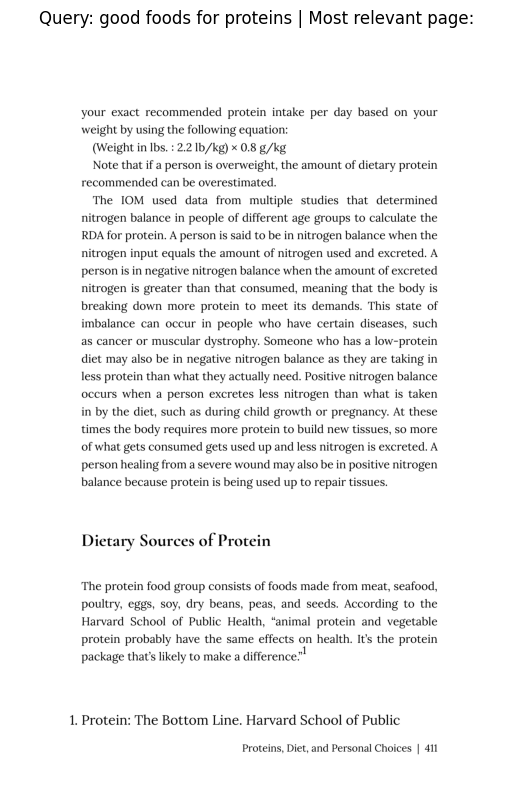

In [35]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)

page = doc.load_page(411 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype = np.uint8).reshape(img.h,img.w,img.n)

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most relevant page: ")
plt.axis("off")# Turn off axis

## Similarity measures: Dot product and Cosine similarity

Dot product and Cosine Similarity are two of the most common similarity measures in regards to vectors

Closer the vectors, higher their similarity scores and vice versa

Vetors have direcion i.e which way its pointing and magnitude i.e. how long it is

In [36]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1672e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7766e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0475e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3388e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9305e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4899e-04, -9.9662e-02,  4.9

### Dot Product

- It meaures the magnitude and direction between the two vectors
- Vectors aligned in direction and magnitude have a higher +ve value
- Vectors that are opposite in direction and magnitude have higher -ve value
- CODE: torch.dot | np.dot | sentence_transformers.util.dot_score

### Cosine Similarity

- First vectors are normalized by magnitude so as to compare more on basis of direction.
- Vectors aligned in direction have closer to 1 value
- Vectors in opposite directions have closer to -1 value
- CODE: torch.nn.functional.cosine_similarity | 1 - scipy.spatial.distance.cosine | sentence_transformers.util.cos_sim

Out of these two choosing the search measure depends upon the embeddings.

- If the embedding model returns already normalized outputs [i.e. all the embeddings are of same magnitude], you can go with dot product

- If the embedding model doesn't return normalized outputs [i.e. all the embeddings are not of same magnitude], you should go with cosine similarity

- Choosing the search meaure also depends upon what kind of data you are giving to the embedding model [i.e. image, text, audio etc.]

In [37]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1,vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Eculidean / L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)


# Example usage:
vector1 = torch.tensor([1,2,3],dtype=torch.float32)
vector2 = torch.tensor([1,2,3],dtype=torch.float32)
vector3 = torch.tensor([1,4,9],dtype=torch.float32)
vector4 = torch.tensor([-1,-2,-3],dtype=torch.float32)

# Calculate Dot Products
print("dot_product between vector1 and vector2: ", dot_product(vector1,vector2))
print("dot_product between vector1 and vector3: ", dot_product(vector1,vector3))
print("dot_product between vector1 and vector4: ", dot_product(vector1,vector4))

# Calculate Cosine Similaritu
print("cosine_similarity between vector1 and vector2: ", cosine_similarity(vector1,vector2))
print("cosine_similarity between vector1 and vector3: ", cosine_similarity(vector1,vector3))
print("cosine_similarity between vector1 and vector4: ", cosine_similarity(vector1,vector4))

dot_product between vector1 and vector2:  tensor(14.)
dot_product between vector1 and vector3:  tensor(36.)
dot_product between vector1 and vector4:  tensor(-14.)
cosine_similarity between vector1 and vector2:  tensor(1.0000)
cosine_similarity between vector1 and vector3:  tensor(0.9719)
cosine_similarity between vector1 and vector4:  tensor(-1.0000)


*vector1 and vector2 are identical so they should have higer similarity value but in dor product vector1 and vector3 have higher value because of magnitue.*

*this is why we normalize them so magnitude doesn't pay major role in finding siliarity and direction does*

### Functionizing the sementic search pipeline (retreival)

Let's put all the steps from above for sementic search into a function or two so as to repeat the workflow

In [38]:
def retrieve_relevant_resources(query: str,
                               embeddings: torch.tensor,
                               model: SentenceTransformer = embedding_model,
                               n_resources_to_return: int = 5,
                               print_time: bool=True):
    # Embeds a query with model and returns top k scores and indices from embeddings

    
    query_embedding = model.encode(query, convert_to_tensor=True)

    start_time  = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f}")

    scores, indices = torch.topk(input=dot_scores,
                                k = n_resources_to_return)
    return scores,indices

In [39]:
retrieve_relevant_resources(query = "Foods high in fiber", embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00024


(tensor([0.6964, 0.6810, 0.5566, 0.5344, 0.5187]),
 tensor([ 418,  360,  358, 1047,  412]))

In [40]:
def print_top_results_and_scores(query: str,
                               embeddings: torch.tensor,
                               pages_and_chunks: list[dict]=pages_and_chunks,
                               n_resources_to_return: int = 5):
    # Finds relevant passages given a query and prints them out along with their scores

    scores,indices = retrieve_relevant_resources(query=query,
                                                 embeddings=embeddings,
                                                n_resources_to_return=n_resources_to_return)

    for score,idx in zip(scores,indices):
        print(f"Score: {score:.4f}")
        print("Text: ")
        print(print_wrapped(pages_and_chunks[idx]["sentence_chunk"]))
        print(f"Page Number: {pages_and_chunks[idx]["page_number"]}")
        print("\n")

In [41]:
query = "Foods high in fiber"
retrieve_relevant_resources(query = query, embeddings=embeddings)
print_top_results_and_scores(query = query, embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00009
[INFO] Time taken to get scores on 1680 embeddings: 0.00010
Score: 0.6964
Text: 
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
None
Page Number: 276


Score: 0.6810
Text: 
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large int

### Getting an LLM for local generation

This process will also work with an API if you don't want to run the LLM locally.
generative LLM? Takes in text input -> Generayes text output

#### Which LLM should you use?

- Run the LLM locally? If so, you need an LLM that your system can run easily and how much compute power can you dedicate to the LLM: *Depends on how much hardware vram is available*

#### the -it in the LLM models?

when you see and research various LLM models to use you will come across models like: gemma-7b and gemma-7b-it. The -it stands for instruction tuned which means it will not only chat with you but follow the specific instructions entered

### Checking local GPU memory available

Compatable only for Metal framework compatible GPU's like Apple silicon GPU's

*to run this code first run the command: pip install pyobjc*

In [42]:

import objc
from Cocoa import *
from Metal import *

device = MTLCreateSystemDefaultDevice()

if device:
    gpu_name = device.name()
    vram_bytes = device.recommendedMaxWorkingSetSize()
    
    gpu_memory_gb = vram_bytes / (2**30)
    
    print(f"GPU Name: {gpu_name}")
    print(f"GPU VRAM (approx.): {gpu_memory_gb:.2f} GB")
else:
    print("No Metal-capable GPU found.")


GPU Name: Apple M3
GPU VRAM (approx.): 10.67 GB


Compatable for NVIDIA GPUs

```
import torch
gpu_memory_bytes = torch.cuda.get_device_properties[0].total_memory
gpu_memory_gb = gpu_memory_bytes / (2**30)
print(f"Available GPU memory: {gpu_memory_gb} GB")
```

In [43]:

#Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")


GPU memory: 10.666671752929688 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


Notes: 
* To use the 'gemma-7b-it' or other gemmaa models, you need to have a hugging face account and have to accept terms & conditions on hugging face
* To download and run locally from hugging face, need to sign in to hugging face cli

### Loading LLM Locally

We will be now loading the LLM model locally using Higging Face transformers

The model used in this notebook is gemma-2b-it

things needed to run a model locally:
1. A quantization config [optional]: A config on what percision to load the model in (e.g. 8bit, 4bit etc)
2. A model ID: this will tell transformers which model/token to load
3. A tokenizer:  this turns text into numbers ready for LLM [tokenizer is different to embedding number]
4. An LLM model: this will be used to generate text based on input


> **Note:** There are many tips nd tricks on loading/making LLMs work faster. One of the best ones is flash_attn [Flash Attention 2]

### To use the model you need to have access auth for it on huggingface

To get the access

- Create hugging face account
- Go to the model page
- Apply for the access
- Once you request is accepted you can work with the model locally
- For doing so download the HuggingFace CLI and login into your account and then you can access it

If you don't have the authorization, you can use API to do so.
Example: GroQ API and the model 'gemma2-9b-it' you can use it by going on https://console.groq.com/keys, generating a key and using the API

In [60]:
import torch
from transformers import AutoTokenizer,AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config
# Note: Requires pip install bitsandbytes accelarate
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                        bnb_4bit_compute_dtype=torch.float16)

# Bonus: flash attention 2 - faster attention mechanism
# Flash attention 2 requires a GPU with a compute compatability score of 8.0+ 
# run the command - torch.cuda.get_device_capability(0)[0] to get the compute compatability

if(is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot product attention

# 2. Pick a model we want to use
model_id = "google/gemma-2b-it"

# 3. Instantiate tokenizer - turns text into tokens
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model

llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                torch_dtype=torch.float16,
                                                quantization_config = quantization_config if use_quantization_config else None,
                                                low_cpu_mem_usage=False,
                                                attn_implementation=attn_implementation)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

To view total parameters in gemma-2b-it model

In [61]:
def get_model_num_params(model:torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])
get_model_num_params(llm_model)

2506172416

In [62]:
def get_model_mem_size(model:torch.nn.Module):
    mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])

    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return{"model_mem_bytes": model_mem_bytes,
          "model_mem_mb": round(model_mem_mb,2),
          "model_mem_gb": round(model_mem_gb,2)}
get_model_mem_size(llm_model)

{'model_mem_bytes': 5079453696, 'model_mem_mb': 4844.14, 'model_mem_gb': 4.73}

We got the size of the model

### Generating text with our LLM

* Note: Some models have been trained/tuned to generate text with a specific template in mind

Because 'gemma-2b-it' has been trained in an instruction-tuned manner, we should follow the instruction template for the best results

### For the local LLM

* To make prompt in the template of the model.
```
input_text = "What are macronutrients and what roles do they play in human body?"
print(f"Input text:\n{input_text}")

#create a prompt template for the instriction tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text,
    }
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                      tokenizer=False,
                                      add_generation=True)
print(f"\nPrompt(formatted): \n{prompt}")
```

* Text generation.
```
%%time

#tokenize the input text and send it to the GPU
input_ids = tokenizer(prompt,
                        return_tensors="pt").to("cpu") #cuda for GPU
# generate outputs from local LLMs
outputs = llm_model.generate(**input_ids,
                            max_new_tokens=256)
print(f"Model Output (tokens): \n{outputs[0]}\n") #gives numbers as outputs and we need to convert it to text
```

* Decode output
```
# Decode the output tokens to text
output_decoded = tokenizer.decode(outputs[0])
print(f"Model Output (decoded): \n{output_decoded}\n")
```

In [73]:
input_text = "How long should infants be breastfed for?"
print(f"Input text:\n{input_text}")

#create a prompt template for the instriction tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text,
    }
]
# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation=True)
print(f"\nPrompt(formatted): \n{prompt}")

Input text:
How long should infants be breastfed for?

Prompt(formatted): 
<bos><start_of_turn>user
How long should infants be breastfed for?<end_of_turn>



In [74]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-2b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_w

In [75]:
%%time

#tokenize the input text and send it to the GPU
input_ids = tokenizer(prompt,
                        return_tensors="pt").to("cpu") #cuda for GPU

# generate outputs from local LLMs
outputs = llm_model.generate(**input_ids,
                            max_new_tokens=256)

print(f"Model Output (tokens): \n{outputs[0]}\n") #gives numbers as outputs and we need to convert it to text


Model Output (tokens): 
tensor([     2,      2,    106,   1645,    108,   2299,   1497,   1412,  45770,
           614,  14665,  30629,    604, 235336,    107,    108, 117039,   9512,
           603,    573,   1963,   2960,    604,  45770, 235269,    578,  84810,
          1412,    614,   7822,    685,   1497,    685,   2145,   5290,    578,
          5760,    708,   9606,    578,  10750, 235265,   2456,    603,    793,
          1142, 115794,    604,   1368,   1497,  45770,   1412,    614,  14665,
         30629, 235269,    901,  12930,   5656,  84810,    604,    696,   3476,
        235248, 235318,   4063, 235269,    675,    573,   4984,    577,   5374,
         84810,    604,    685,   1497,    685,   2145,   5290,    578,   5760,
         12005, 235265,      1])

CPU times: user 25.9 s, sys: 1.19 s, total: 27.1 s
Wall time: 6.78 s


In [76]:
# Decode the output tokens to text
output_decoded = tokenizer.decode(outputs[0])
print(f"Model Output (decoded): \n{output_decoded}\n")

Model Output (decoded): 
<bos><bos><start_of_turn>user
How long should infants be breastfed for?<end_of_turn>
Breast milk is the best food for infants, and breastfeeding should be continued as long as both mother and baby are healthy and comfortable. There is no set timeframe for how long infants should be breastfed, but experts recommend breastfeeding for at least 6 months, with the option to continue breastfeeding for as long as both mother and baby desire.<eos>



Making a list of questions to randomly feed to our model

In [78]:
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [92]:
query = random.choice(query_list)

print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What are the macronutrients, and what roles do they play in the human body?
[INFO] Time taken to get scores on 1680 embeddings: 0.00077


(tensor([0.7302, 0.7233, 0.6962, 0.6942, 0.6416]),
 tensor([42, 47, 46, 41, 52]))

### Augmenting our prompt with context items

Retreival - Done

Generation - Done

Now we need to augment the contexts and feed it to our LLM

The concept of augmenting a prompt with context items is also reffered to as prompt engineering

Prompt engineering is an active field of research and various new techniques are being found out

Let's create a function to format a prompt with context items

In [89]:
def prompt_formatter(query: str,
                     context_items:list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    prompt = base_prompt.format(context=context,query=query)
    return prompt

query = random.choice(query_list)

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query=query,context_items=context_items)

print(f"Prompt: {prompt}")

[INFO] Time taken to get scores on 1680 embeddings: 0.00009
Prompt: Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.

Now use the following context items to answer the user query:
- Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calorie

Prompt example:
```
Based on the following contextx:
- abcd
- efgh
- ijkl
- mnop
- qrst
 Please answer the following query: What are the macronutrients and what do they do?
Answer:
```

In [90]:
%%time

#tokenize the input text and send it to the GPU
input_ids = tokenizer(prompt,
                        return_tensors="pt").to("cpu") #cuda for GPU

# generate outputs from local LLMs
outputs = llm_model.generate(**input_ids,
                             temperature=0.7,
                             do_sample=True,
                            max_new_tokens=256)

output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"Model Output (decoded): \n{output_text}\n")

Query: What are the macronutrients, and what roles do they play in the human body?
Model Output (decoded): 
<bos>Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.

Now use the following context items to answer the user query:
- Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one 

### Functionize LLM answering feature

In [98]:
def ask(query: str,
       temperature: float=0.7,
       max_new_tokens: int=256,
       format_answer_text=True,
       return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an asnwer to the query based on the relevant resources.
    """

    # Get scores and indices of the top relevant results
    scores, indices = retrieve_relevant_resources(query = query, 
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add scores to context items
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    #format the prompt with context items
    prompt = prompt_formatter(query=query,
                             context_items=context_items)

    # generate
    input_ids =  tokenizer(prompt,return_tensors="pt").to("cpu")

    outputs = llm_model.generate(**input_ids,
                                temperature=temperature,
                                do_sample=True,
                                max_new_tokens=max_new_tokens)

    #decode tokens to texts
    output_text = tokenizer.decode(outputs[0])

    #Format answer
    if format_answer_text:
        #replace prompt with special tokens
        output_text = output_text.replace(prompt,"").replace("<bos>","").replace("<eos>","")

    if return_answer_only:
        return output_text

    return output_text,context_items

In [100]:
query = random.choice(query_list)
print(f"Query {query}")
ask(query=query,temperature=0.2,return_answer_only=False)

Query What role does fibre play in digestion? Name five fibre containing foods.
[INFO] Time taken to get scores on 1680 embeddings: 0.00009


(' Fibre plays a crucial role in digestion by providing structure and support for the cells in the digestive tract. It also helps to regulate blood glucose levels by slowing down the absorption of glucose from food. Five fibre-containing foods are: whole grains, fruits, vegetables, legumes, and nuts.',
 [{'page_number': 1086,
   'sentence_chunk': 'Image by Allison Calabrese / CC BY 4.0 fiber intake because of what the breakdown products of the fiber do for the colon. The bacterial breakdown of fiber in the large intestine releases short-chain fatty acids. These molecules have been found to nourish colonic cells, inhibit colonic inflammation, and stimulate the immune system (thereby providing protection of the colon from harmful substances). Additionally, the bacterial indigestible fiber, mostly insoluble, increases stool bulk and softness increasing transit time in the large intestine and facilitating feces elimination. One phenomenon of consuming foods high in fiber is increased gas, 